In [1]:
using CSV
using DataFrames
using Flux
using HypothesisTests
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [5]:
x_df = decorrelatedvars(x_df);
x_df, _ = minmaxscaledf(x_df);
y_df, y_scalers = minmaxscaledf(y_df);

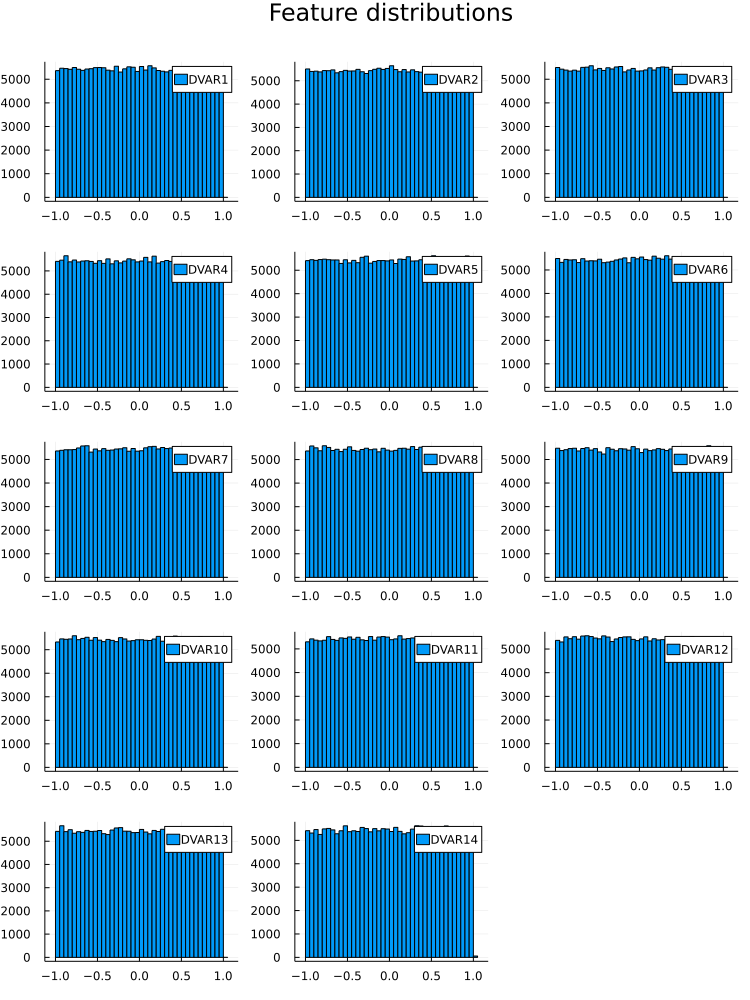

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

In [7]:
x_train_df, x_test_df, y_train_df, y_test_df = traintestsplit(x_df, y_df; read_in=true, path="../indexes/")

x_train = Float32.(Matrix(x_train_df));
x_test = Float32.(Matrix(x_test_df));
y_train = Float32.(Matrix(y_train_df));
y_test = Float32.(Matrix(y_test_df));

- Using preexisting train and test sets


In [8]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [9]:
# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 100, x->σ.(x)),
        (Dense(100, 100, x->σ.(x)) for _ in 1:5)...,
        Dense(100, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [10]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [11]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]
    training_times = Float32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        start_time = time()
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        end_time = time()
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
        push!(training_times, Float32(end_time - start_time))
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=14.735087230801582
epoch 2, loss=9.715465914458036
epoch 3, loss=5.3100099209696054
epoch 4, loss=2.8063150867819786
epoch 5, loss=2.248736104927957
epoch 6, loss=2.0394899901002645
epoch 7, loss=1.8808423904702067
epoch 8, loss=1.7485751239582896
epoch 9, loss=1.7142683621495962
epoch 10, loss=1.6384922787547112
epoch 11, loss=1.6409105034545064
epoch 12, loss=1.5695729134604335
epoch 13, loss=1.5368179734796286
epoch 14, loss=1.5643380163237453
epoch 15, loss=1.4800332793965936
epoch 16, loss=1.4593869457021356
epoch 17, loss=1.432037340477109
epoch 18, loss=1.448522954247892
epoch 19, loss=1.39144786586985
epoch 20, loss=1.4133193334564567
epoch 21, loss=1.3816768410615623
epoch 22, loss=1.3451332245022058
epoch 23, loss=1.336171654984355
epoch 24, loss=1.293643293902278
epoch 25, loss=1.2763221086934209
epoch 26, loss=1.2523270971141756
epoch 27, loss=1.272097415290773
epoch 28, loss=1.2532492317259312
epoch 29, loss=1.2273275647312403
epoch 30, loss=1.232396851293742

epoch 239, loss=0.9203630136325955
epoch 240, loss=0.9299265998415649
epoch 241, loss=0.9373681861907244
epoch 242, loss=0.9243519031442702
epoch 243, loss=0.9318400407209992
epoch 244, loss=0.9220807929523289
epoch 245, loss=0.9115554634481668
epoch 246, loss=0.9193098009563982
epoch 247, loss=0.9324653334915638
epoch 248, loss=0.9162719957530499
epoch 249, loss=0.9169913046061993
epoch 250, loss=0.9150866470299661
epoch 251, loss=0.9209143621847034
epoch 252, loss=0.9273359710350633
epoch 253, loss=0.9198214886710048
epoch 254, loss=0.9312545517459512
epoch 255, loss=0.9158123065717518
epoch 256, loss=0.9454659568145871
epoch 257, loss=0.9086356540210545
epoch 258, loss=0.9121024939231575
epoch 259, loss=0.9158877381123602
epoch 260, loss=0.9377498598769307
epoch 261, loss=0.9120452455244958
epoch 262, loss=0.9159018732607365
epoch 263, loss=0.9314871565438807
epoch 264, loss=0.9102881117723882
epoch 265, loss=0.9094395441934466
epoch 266, loss=0.9133454323746264
epoch 267, loss=0.92

epoch 473, loss=0.8806175962090492
epoch 474, loss=0.8686528224498034
epoch 475, loss=0.8647671239450574
epoch 476, loss=0.8757917461916804
epoch 477, loss=0.8690350772812963
epoch 478, loss=0.8684873064048588
epoch 479, loss=0.8653354602865875
epoch 480, loss=0.8769368934445083
epoch 481, loss=0.8632934275083244
epoch 482, loss=0.8674967559054494
epoch 483, loss=0.8643316505476832
epoch 484, loss=0.8643067735247314
epoch 485, loss=0.8644868028350174
epoch 486, loss=0.8775133835151792
epoch 487, loss=0.8594240881502628
epoch 488, loss=0.860066244378686
epoch 489, loss=0.8683450114913285
epoch 490, loss=0.8644140474498272
epoch 491, loss=0.8726661382243037
epoch 492, loss=0.866133023519069
epoch 493, loss=0.859697503503412
epoch 494, loss=0.8641165993176401
epoch 495, loss=0.8653520327061415
epoch 496, loss=0.8695399593561888
epoch 497, loss=0.8662487771362066
epoch 498, loss=0.8633036753162742
epoch 499, loss=0.8653074917383492
epoch 500, loss=0.8646985939703882
epoch 501, loss=0.87063

epoch 707, loss=0.8327255505137146
epoch 708, loss=0.8470700103789568
epoch 709, loss=0.841357693541795
epoch 710, loss=0.8400929742492735
epoch 711, loss=0.837297482881695
epoch 712, loss=0.8472143011167645
epoch 713, loss=0.8348393002524972
epoch 714, loss=0.8344698869623244
epoch 715, loss=0.8421456217765808
epoch 716, loss=0.8403651905246079
epoch 717, loss=0.8417670582421124
epoch 718, loss=0.8363821296952665
epoch 719, loss=0.8528121341951191
epoch 720, loss=0.8374356608837843
epoch 721, loss=0.8324357732199132
epoch 722, loss=0.8355135759338737
epoch 723, loss=0.8361360859125853
epoch 724, loss=0.8416764722205698
epoch 725, loss=0.8301434880122542
epoch 726, loss=0.8323194831609726
epoch 727, loss=0.8353954623453319
epoch 728, loss=0.832135321572423
epoch 729, loss=0.8375240215100348
epoch 730, loss=0.830575620289892
epoch 731, loss=0.838366047013551
epoch 732, loss=0.8315251138992608
epoch 733, loss=0.8299435279332101
epoch 734, loss=0.8380122724920511
epoch 735, loss=0.8354483

epoch 941, loss=0.8160804598592222
epoch 942, loss=0.8189844344742596
epoch 943, loss=0.8163053318858147
epoch 944, loss=0.8210116680711508
epoch 945, loss=0.8199735903181136
epoch 946, loss=0.8141219750978053
epoch 947, loss=0.8212052010931075
epoch 948, loss=0.8159565287642181
epoch 949, loss=0.8198882401920855
epoch 950, loss=0.8130881846882403
epoch 951, loss=0.8145814565941691
epoch 952, loss=0.8160096202045679
epoch 953, loss=0.822295636869967
epoch 954, loss=0.8137465519830585
epoch 955, loss=0.8177827675826848
epoch 956, loss=0.8143051778897643
epoch 957, loss=0.8142101466655731
epoch 958, loss=0.8117354074493051
epoch 959, loss=0.81395403156057
epoch 960, loss=0.8281894880346954
epoch 961, loss=0.8221360645256937
epoch 962, loss=0.8193483091890812
epoch 963, loss=0.8138465606607497
epoch 964, loss=0.8199401707388461
epoch 965, loss=0.809055223595351
epoch 966, loss=0.8121378193609416
epoch 967, loss=0.8163167936727405
epoch 968, loss=0.812755617313087
epoch 969, loss=0.8197594

epoch 1171, loss=0.7977565848268569
epoch 1172, loss=0.7982601746916771
epoch 1173, loss=0.8028106018900871
epoch 1174, loss=0.8016376332379878
epoch 1175, loss=0.7999900355935097
epoch 1176, loss=0.7954952432774007
epoch 1177, loss=0.8041038000956178
epoch 1178, loss=0.800576361361891
epoch 1179, loss=0.8051690347492695
epoch 1180, loss=0.7994042746722698
epoch 1181, loss=0.8089688559994102
epoch 1182, loss=0.8003222737461329
epoch 1183, loss=0.7965873680077493
epoch 1184, loss=0.8065448794513941
epoch 1185, loss=0.7994811246171594
epoch 1186, loss=0.7974315150640905
epoch 1187, loss=0.8106097467243671
epoch 1188, loss=0.8043507938273251
epoch 1189, loss=0.7988295638933778
epoch 1190, loss=0.8046382437460124
epoch 1191, loss=0.7977507086470723
epoch 1192, loss=0.7956498148851097
epoch 1193, loss=0.8071936136111617
epoch 1194, loss=0.7963275681249797
epoch 1195, loss=0.7961505060084164
epoch 1196, loss=0.8000257005915046
epoch 1197, loss=0.7965699909254909
epoch 1198, loss=0.7956291618

epoch 1399, loss=0.7832909282296896
epoch 1400, loss=0.782451483886689
epoch 1401, loss=0.7884411420673132
epoch 1402, loss=0.785299080889672
epoch 1403, loss=0.7914477535523474
epoch 1404, loss=0.7843367024324834
epoch 1405, loss=0.7832905068062246
epoch 1406, loss=0.7890957244671881
epoch 1407, loss=0.7833209251984954
epoch 1408, loss=0.7887531481683254
epoch 1409, loss=0.792337897233665
epoch 1410, loss=0.7875468940474093
epoch 1411, loss=0.7822389397770166
epoch 1412, loss=0.7872517323121428
epoch 1413, loss=0.7855216455645859
epoch 1414, loss=0.7876761755906045
epoch 1415, loss=0.7831425396725535
epoch 1416, loss=0.7831012820824981
epoch 1417, loss=0.7935116277076304
epoch 1418, loss=0.7846611477434635
epoch 1419, loss=0.7814716934226453
epoch 1420, loss=0.7884242315776646
epoch 1421, loss=0.789000797085464
epoch 1422, loss=0.7806953559629619
epoch 1423, loss=0.7794862207956612
epoch 1424, loss=0.7845829823054373
epoch 1425, loss=0.785019098315388
epoch 1426, loss=0.79015419678762

epoch 1627, loss=0.7654198845848441
epoch 1628, loss=0.7679054574109614
epoch 1629, loss=0.7663895441219211
epoch 1630, loss=0.7692447160370648
epoch 1631, loss=0.7680998956784606
epoch 1632, loss=0.7651695013046265
epoch 1633, loss=0.7685154261998832
epoch 1634, loss=0.7740710885263979
epoch 1635, loss=0.7690550135448575
epoch 1636, loss=0.7675127037800848
epoch 1637, loss=0.7708167131058872
epoch 1638, loss=0.7729436345398426
epoch 1639, loss=0.7673471244052052
epoch 1640, loss=0.7698313742876053
epoch 1641, loss=0.7696096929721534
epoch 1642, loss=0.7790328003466129
epoch 1643, loss=0.7683936031535268
epoch 1644, loss=0.7661782912909985
epoch 1645, loss=0.7644011373631656
epoch 1646, loss=0.7715461361221969
epoch 1647, loss=0.7659745356068015
epoch 1648, loss=0.7710322588682175
epoch 1649, loss=0.7678974410519004
epoch 1650, loss=0.7744853869080544
epoch 1651, loss=0.7684597261250019
epoch 1652, loss=0.7683595074340701
epoch 1653, loss=0.7804580959491432
epoch 1654, loss=0.774264433

epoch 1855, loss=0.7532796203158796
epoch 1856, loss=0.7552270996384323
epoch 1857, loss=0.7728786091320217
epoch 1858, loss=0.7601044019684196
epoch 1859, loss=0.7474490371532738
epoch 1860, loss=0.7486541583202779
epoch 1861, loss=0.7520032948814332
epoch 1862, loss=0.7466173809953034
epoch 1863, loss=0.7501114872284234
epoch 1864, loss=0.7467691209167242
epoch 1865, loss=0.7468246850185096
epoch 1866, loss=0.7508880565874279
epoch 1867, loss=0.7515338086523116
epoch 1868, loss=0.754825143609196
epoch 1869, loss=0.7612611800432205
epoch 1870, loss=0.74990244070068
epoch 1871, loss=0.7513587195426226
epoch 1872, loss=0.7492652488872409
epoch 1873, loss=0.7487362208776176
epoch 1874, loss=0.7533165588974953
epoch 1875, loss=0.7480714931152761
epoch 1876, loss=0.7467479803599417
epoch 1877, loss=0.751304934732616
epoch 1878, loss=0.7468232805840671
epoch 1879, loss=0.7484192349947989
epoch 1880, loss=0.7507244357839227
epoch 1881, loss=0.7473460223991424
epoch 1882, loss=0.7477863617241

epoch 2083, loss=0.7329403695184737
epoch 2084, loss=0.7339268582873046
epoch 2085, loss=0.7295401529408991
epoch 2086, loss=0.7277890853583813
epoch 2087, loss=0.7374895545653999
epoch 2088, loss=0.7292385390028358
epoch 2089, loss=0.7329039662145078
epoch 2090, loss=0.7370145521126688
epoch 2091, loss=0.7322051338851452
epoch 2092, loss=0.7278281073085964
epoch 2093, loss=0.7340314565226436
epoch 2094, loss=0.7300312118604779
epoch 2095, loss=0.7346342885866761
epoch 2096, loss=0.7281327357050031
epoch 2097, loss=0.729124422185123
epoch 2098, loss=0.7313812617212534
epoch 2099, loss=0.7245509917847812
epoch 2100, loss=0.7295927130617201
epoch 2101, loss=0.7282496667467058
epoch 2102, loss=0.7320046434178948
epoch 2103, loss=0.7277856464497745
epoch 2104, loss=0.7271804604679346
epoch 2105, loss=0.7287004315294325
epoch 2106, loss=0.7282576416619122
epoch 2107, loss=0.72987623186782
epoch 2108, loss=0.7285370428580791
epoch 2109, loss=0.7282486944459379
epoch 2110, loss=0.734260187949

epoch 2311, loss=0.7100105022545904
epoch 2312, loss=0.7077731755562127
epoch 2313, loss=0.7106463010422885
epoch 2314, loss=0.7129172021523118
epoch 2315, loss=0.7094928922597319
epoch 2316, loss=0.7164798509329557
epoch 2317, loss=0.707923591369763
epoch 2318, loss=0.711740608792752
epoch 2319, loss=0.7113633535336703
epoch 2320, loss=0.7119729910045862
epoch 2321, loss=0.7072282624430954
epoch 2322, loss=0.7110852997284383
epoch 2323, loss=0.7108452047687024
epoch 2324, loss=0.7201002417132258
epoch 2325, loss=0.7142289073672146
epoch 2326, loss=0.7182381895836443
epoch 2327, loss=0.7079488588497043
epoch 2328, loss=0.7091795625165105
epoch 2329, loss=0.7144997771829367
epoch 2330, loss=0.7058927265461534
epoch 2331, loss=0.7069590070750564
epoch 2332, loss=0.7070503900758922
epoch 2333, loss=0.7094721978064626
epoch 2334, loss=0.7136164861731231
epoch 2335, loss=0.7116800418589264
epoch 2336, loss=0.7044393203686923
epoch 2337, loss=0.7114727152511477
epoch 2338, loss=0.71673633484

In [12]:
# write out training time information
save_training_times = true
if save_training_times
    CSV.write("../results/timing_results/julia_cpu_d5_w100.csv", DataFrame(col1 = training_times));
end

"../results/timing_results/julia_cpu_d5_w100.csv"

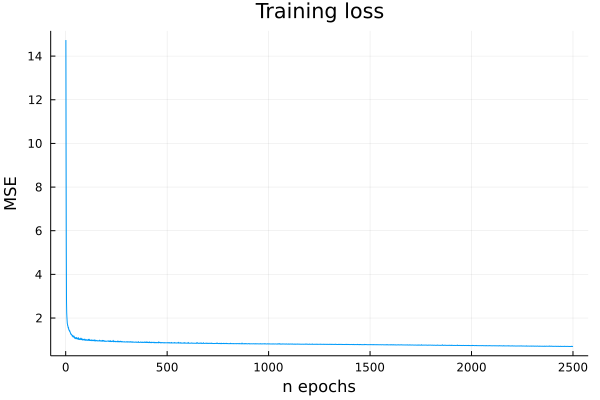

In [13]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [14]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [15]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9343627
r2 on test set: 0.91963834


In [16]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [17]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.93435746
adjustedr2 on test set: 0.91961235


In [18]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.042089593
mae on test set: 0.04594063


In [19]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.015952928
mae on test set for OBJ1: 0.017657448
mae on training set for OBJ2: 0.071997814
mae on test set for OBJ2: 0.07577532
mae on training set for OBJ3: 0.009525325
mae on test set for OBJ3: 0.0097985
mae on training set for OBJ4: 0.0062200334
mae on test set for OBJ4: 0.0063183624
mae on training set for OBJ5: 0.07615048
mae on test set for OBJ5: 0.08475578
mae on training set for OBJ6: 0.07269097
mae on test set for OBJ6: 0.08133838


In [20]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [21]:
y_scalers

Dict{String, MinMaxScaler} with 6 entries:
  "OBJ4" => MinMaxScaler(0.00582, 1.34901)
  "OBJ6" => MinMaxScaler(0.00697, 0.10912)
  "OBJ2" => MinMaxScaler(0.0542, 0.087)
  "OBJ3" => MinMaxScaler(35.05, 386.37)
  "OBJ5" => MinMaxScaler(0.00731, 0.10398)
  "OBJ1" => MinMaxScaler(1.53, 99.5)

In [22]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = y_scalers["OBJ$i"]
    
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.016178916485625233
MAPE on test set for OBJ2: 0.018221530208571295
MAPE on test set for OBJ3: 0.01502389139730867
MAPE on test set for OBJ4: 0.0781698743103035
MAPE on test set for OBJ5: 0.11842654292406164
MAPE on test set for OBJ6: 0.11989494841631633


## Plotting / results

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

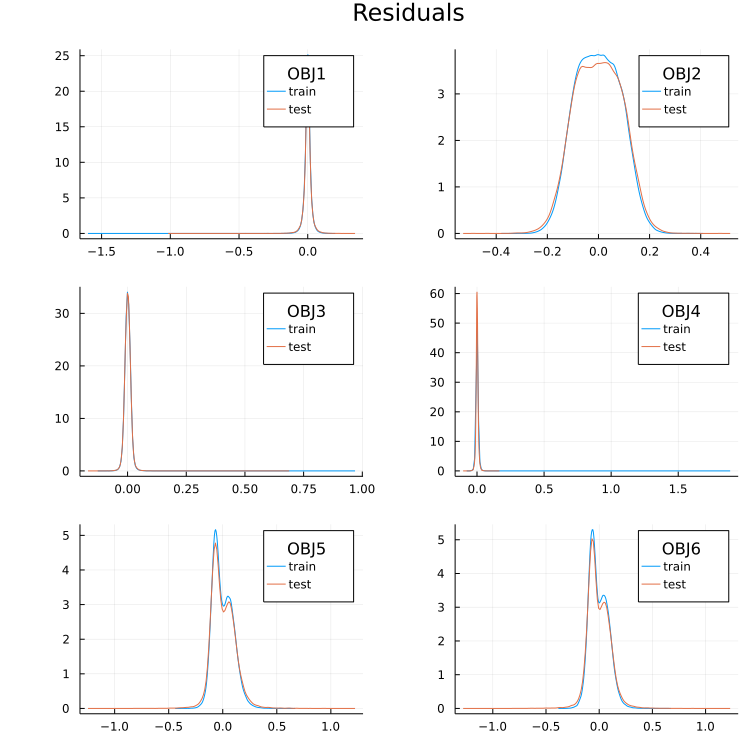

In [23]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

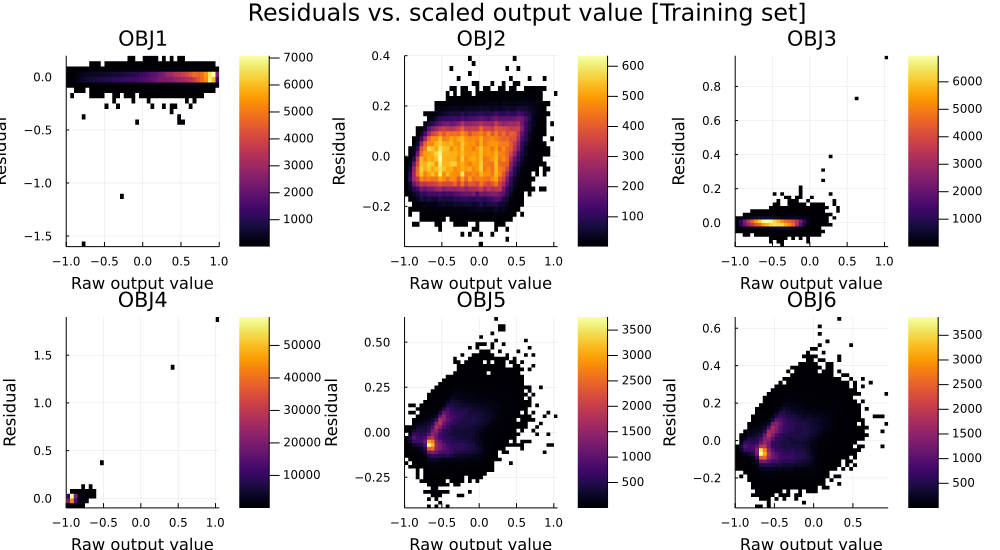

In [24]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

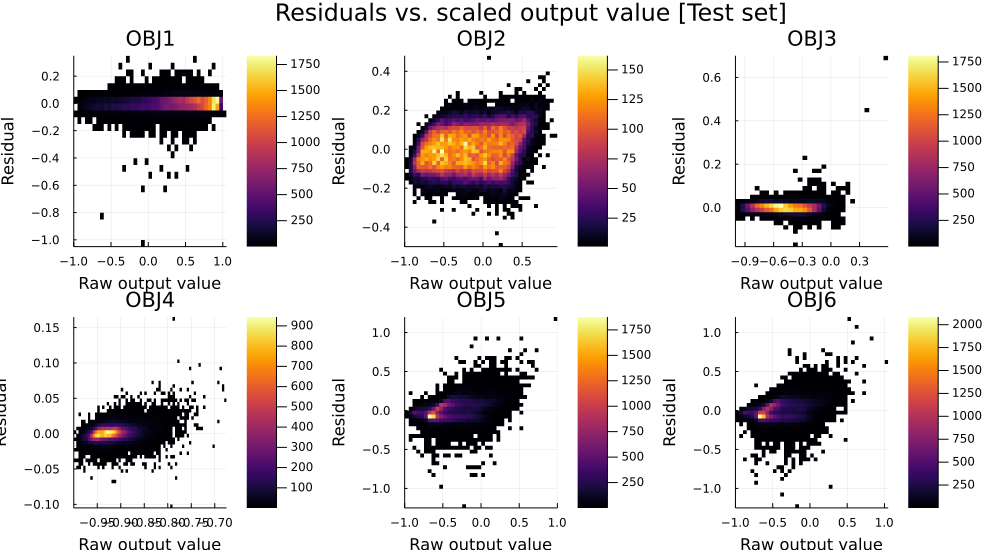

In [25]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

How can we explain the two-band structure in the residuals of OBJ5 and OBJ6?

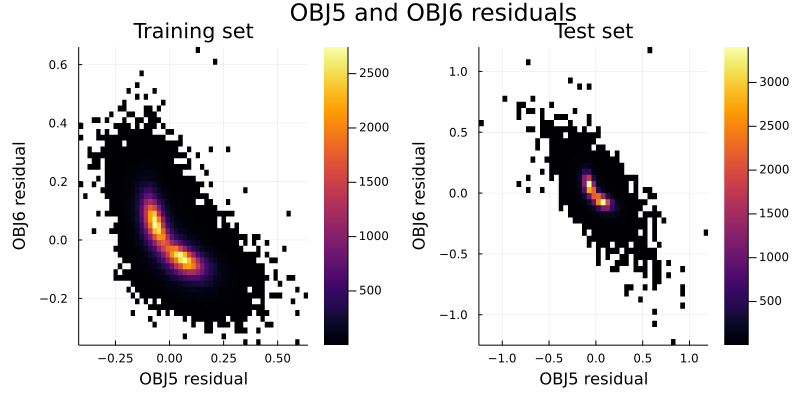

In [26]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    residuals_train[:, 5], residuals_train[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    residuals_test[:, 5], residuals_test[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(800, 400), plot_title="OBJ5 and OBJ6 residuals",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

In [27]:
using Statistics;
println("Correlation between resids for 5 and 6 for train:")
println(Statistics.cor(residuals_train[:, 5], residuals_train[:, 6]))
println("Correlation between resids for 5 and 6 for test:")
println(Statistics.cor(residuals_test[:, 5], residuals_test[:, 6]))

Correlation between resids for 5 and 6 for train:
-0.7444398
Correlation between resids for 5 and 6 for test:
-0.74663603


In [28]:
using GLM;

fm = @formula(x6 ~ x5)
linearRegressor = lm(fm, DataFrame(residuals_train))

LoadError: MethodError: no method matching delbeta!(::GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}, ::Vector{Float32})
[0mClosest candidates are:
[0m  delbeta!([91m::GLM.DensePredQR{T}[39m, ::Vector{T}) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:75
[0m  delbeta!([91m::GLM.DensePredChol{T, <:Cholesky}[39m, ::Vector{T}) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:129
[0m  delbeta!(::GLM.DensePredChol{T, <:CholeskyPivoted}, [91m::Vector{T}[39m) where T<:Union{Float32, Float64} at ~/.julia/packages/GLM/zj7GL/src/linpred.jl:134
[0m  ...

In [29]:
r2(linearRegressor)

LoadError: UndefVarError: linearRegressor not defined

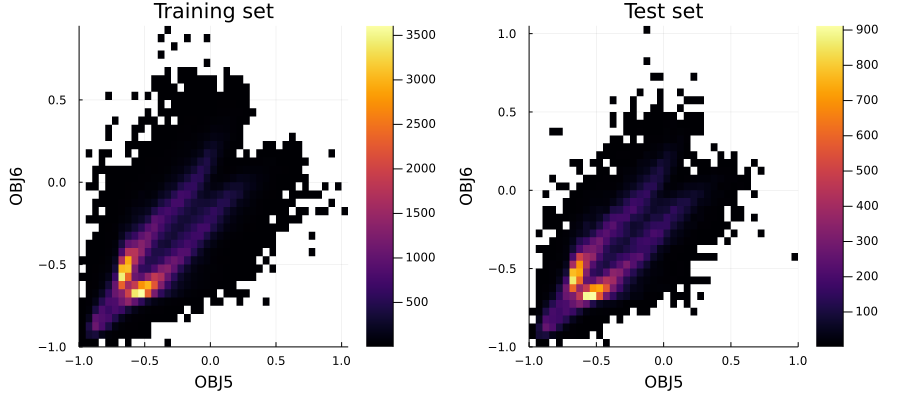

In [30]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train[:, 5], y_train[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test[:, 5], y_test[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

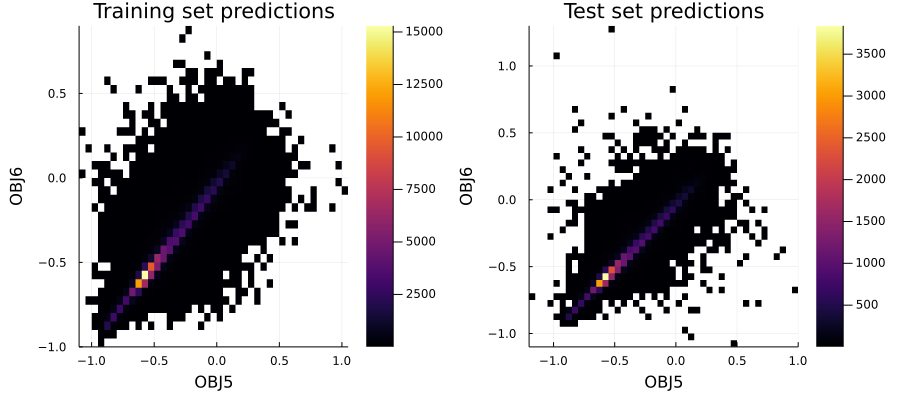

In [31]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train_preds[:, 5], y_train_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set predictions", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test_preds[:, 5], y_test_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set predictions", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

In [32]:
# how does the model do at predicting avg(obj5, obj6) ?
# obj5
temp_train_preds_normalized_5 = y_train_preds[:, 5]
temp_train_trues_normalized_5 = y_train[:, 5]

temp_test_preds_normalized_5 = y_test_preds[:, 5]
temp_test_trues_normalized_5 = y_test[:, 5]

# obj6
temp_train_preds_normalized_6 = y_train_preds[:, 6]
temp_train_trues_normalized_6 = y_train[:, 6]

temp_test_preds_normalized_6 = y_test_preds[:, 6]
temp_test_trues_normalized_6 = y_test[:, 6]

# unnormalize
y_scaler_5 = y_scalers["OBJ5"]; y_scaler_6 = y_scalers["OBJ6"]

temp_train_preds_original_5 = inverse_transform(y_scaler_5, temp_train_preds_normalized_5)
temp_train_trues_original_5 = inverse_transform(y_scaler_5, temp_train_trues_normalized_5)
temp_test_preds_original_5 = inverse_transform(y_scaler_5, temp_test_preds_normalized_5)
temp_test_trues_original_5 = inverse_transform(y_scaler_5, temp_test_trues_normalized_5)
temp_train_preds_original_6 = inverse_transform(y_scaler_6, temp_train_preds_normalized_6)
temp_train_trues_original_6 = inverse_transform(y_scaler_6, temp_train_trues_normalized_6)
temp_test_preds_original_6 = inverse_transform(y_scaler_6, temp_test_preds_normalized_6)
temp_test_trues_original_6 = inverse_transform(y_scaler_6, temp_test_trues_normalized_6)

# println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
println(
    "MAPE on test set for mean(OBJ5, OBJ6): ",
    mape(
        (temp_test_preds_original_5 .+ temp_test_preds_original_6) ./ 2,
        (temp_test_trues_original_5 .+ temp_test_trues_original_6) ./ 2
    )
)

MAPE on test set for mean(OBJ5, OBJ6): 0.039901708379793815
